In [1]:
from rdkit import rdBase
rdBase.rdkitVersion

'2018.09.3'

In [30]:
import glob
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole

from sklearn import decomposition

import numpy as np
import matplotlib.pyplot as plt

In [6]:
# remove duplicates from array/list lst
def remove_duplicates(lst):
    return list(dict.fromkeys(lst))

In [7]:
path_to_library = '/home/paula/Masterarbeit/KinaseFocusedFragmentLibrary/FragmentLibrary'

# list of folders for each subpocket
folders = glob.glob(path_to_library+'/*')
subpockets = [folder[-2:] for folder in folders]
subpockets

['FP', 'B2', 'AP', 'SE', 'B1', 'GA']

In [62]:
class Fragment:
    def __init__(self, mol, fp, kinase, id):
        self.mol = mol
        self.fp = fp
        self.kinase = kinase
        self.id = id
        

For each subpocket, show:
* Number of fragments
* Number of unique fragments
* 4 fragments with highest number of occurences

FP
Number of fragments:  1811
Number of unique fragments:  835
B2
Number of fragments:  245
Number of unique fragments:  124
AP
Number of fragments:  2670
Number of unique fragments:  1234
SE
Number of fragments:  1487
Number of unique fragments:  629
B1
Number of fragments:  112
Number of unique fragments:  52
GA
Number of fragments:  1202
Number of unique fragments:  431


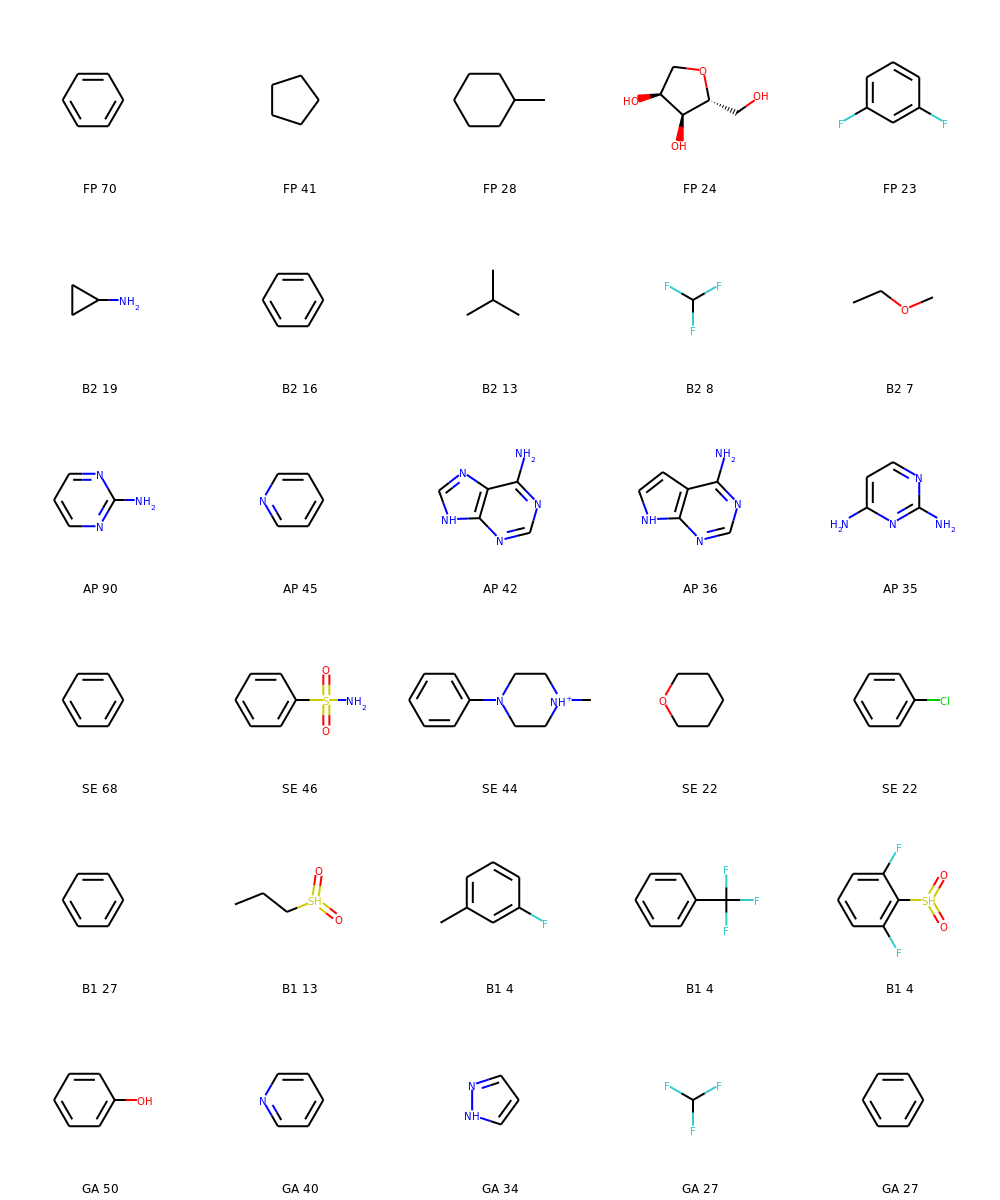

In [63]:
# iterate over subpockets

data = [] # [[(frag, fp, kinase), (frag, fp, kinase), ...],[...]]

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

frags_max = []
legends = []

for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    frag_smiles = []
    data_sb = []
    print(subpocket)
    
    files = glob.glob(folder+'/*.sdf')
    kinases = []
    # iterate over kinases
    for file in files:
        
        fragments = [f for f in Chem.SDMolSupplier(file)]
        # kinase that the fragments correspond to
        kinase = file.split('/')[-1].split('.')[0]
        
        # all fragments for this kinase
        for f, frag in enumerate(fragments):
            # remove dummy atoms from fragments and create smiles
            du = Chem.MolFromSmiles('*')
            h = Chem.MolFromSmiles('[H]', sanitize=False)
            fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
            fixed_frag = Chem.RemoveHs(fixed_frag)
            fragments[f] = fixed_frag
            # smiles for drawing fragment
            frag_smiles.append(Chem.MolToSmiles(fixed_frag))
            # fingerprint of fragment
            fp = rdkit_gen.GetFingerprint(fixed_frag)
            
            data_sb.append((fixed_frag, fp, kinase))
    
    # img = Draw.MolsToGridImage([Chem.MolFromSmiles(fs) for fs in list(set(frag_smiles))], molsPerRow=10,subImgSize=(200,200))
    # img.save(folder+'/all_fragments.png')    
    
    data.append(data_sb)
    
    print('Number of fragments: ', len(frag_smiles))
    print('Number of unique fragments: ', len(set(frag_smiles)))
    
    # fragments with highest occurency
    freq_count = [(a, frag_smiles.count(a)) for a in set(frag_smiles)]
    freq_count.sort(key=lambda x: x[1], reverse=True)
    frag_max = [Chem.MolFromSmiles(frag[0]) for frag in freq_count[:5]]
    
    legends.extend([subpocket+' '+str(frag[1]) for frag in freq_count[:5]])
    frags_max.extend(frag_max)    
    
Draw.MolsToGridImage(frags_max, legends=legends, molsPerRow=5)
    

In [95]:
def get_fps(data_sb):
    return [d[1] for d in data_sb]
def get_mols(data_sb):
    return [d[0] for d in data_sb]
def get_kinases(data_sb):
    return [d[2] for d in data_sb]

Functions needed for Clustering:

In [2]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [65]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps, cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [72]:
def analyze_clusters(clusters, i, cutoff):
    
    # Give a short report about the numbers of clusters and their sizes
    num_clust_g1 = len([c for c in clusters if len(c) == 1])
    num_clust_g5 = len([c for c in clusters if len(c) > 5])
    num_clust_g25 = len([c for c in clusters if len(c) > 25])
    num_clust_g100 = len([c for c in clusters if len(c) > 100])

    print(subpockets[i])
    print("Threshold: ", cutoff)
    print("total # clusters: ", len(clusters))
    print("# clusters with only 1 compound: ", num_clust_g1)
    print("# clusters with >5 compounds: ", num_clust_g5)
    print("# clusters with >25 compounds: ", num_clust_g25)
    print("# clusters with >100 compounds: ", num_clust_g100)

    # Plot the size of the clusters
    fig = plt.figure(1, figsize=(8, 3))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %cutoff), fontsize=10)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

    return None


## Butina Clustering for each subpocket with different cutoffs:

AP
Threshold:  0.0
total # clusters:  1200
# clusters with only 1 compound:  819
# clusters with >5 compounds:  78
# clusters with >25 compounds:  7
# clusters with >100 compounds:  0


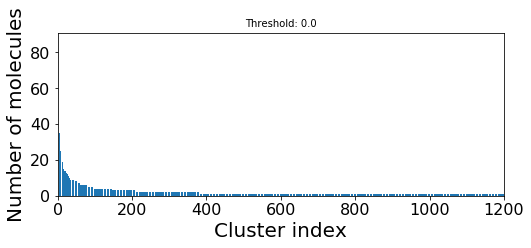

AP
Threshold:  0.1
total # clusters:  1123
# clusters with only 1 compound:  737
# clusters with >5 compounds:  89
# clusters with >25 compounds:  7
# clusters with >100 compounds:  0


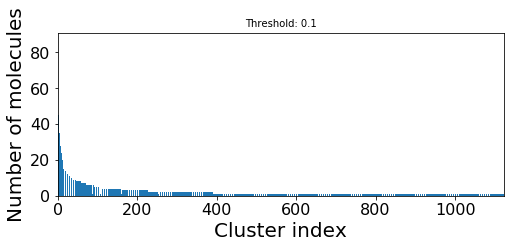

AP
Threshold:  0.2
total # clusters:  919
# clusters with only 1 compound:  560
# clusters with >5 compounds:  99
# clusters with >25 compounds:  9
# clusters with >100 compounds:  0


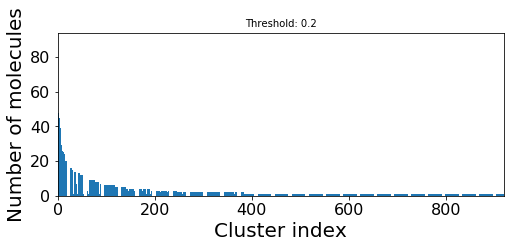

AP
Threshold:  0.30000000000000004
total # clusters:  730
# clusters with only 1 compound:  412
# clusters with >5 compounds:  96
# clusters with >25 compounds:  11
# clusters with >100 compounds:  1


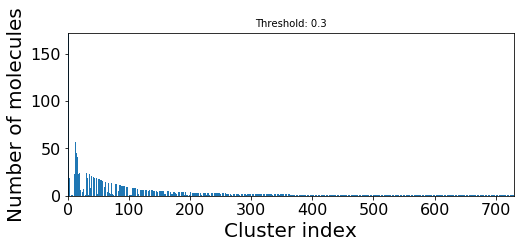

AP
Threshold:  0.4
total # clusters:  560
# clusters with only 1 compound:  294
# clusters with >5 compounds:  96
# clusters with >25 compounds:  18
# clusters with >100 compounds:  2


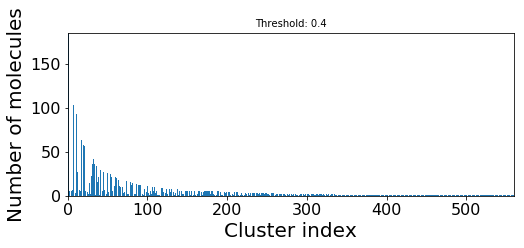

AP
Threshold:  0.5
total # clusters:  392
# clusters with only 1 compound:  182
# clusters with >5 compounds:  82
# clusters with >25 compounds:  18
# clusters with >100 compounds:  5


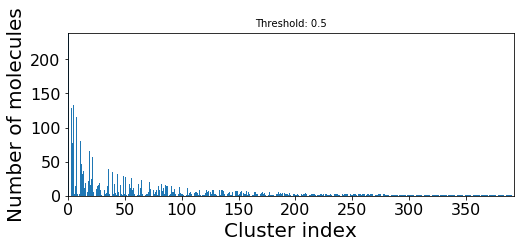

AP
Threshold:  0.6000000000000001
total # clusters:  228
# clusters with only 1 compound:  91
# clusters with >5 compounds:  66
# clusters with >25 compounds:  20
# clusters with >100 compounds:  6


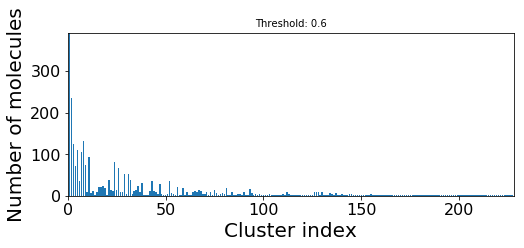

AP
Threshold:  0.7000000000000001
total # clusters:  121
# clusters with only 1 compound:  44
# clusters with >5 compounds:  45
# clusters with >25 compounds:  19
# clusters with >100 compounds:  2


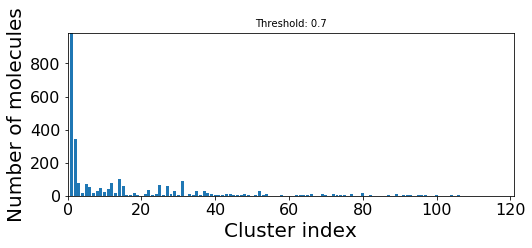

AP
Threshold:  0.8
total # clusters:  42
# clusters with only 1 compound:  9
# clusters with >5 compounds:  16
# clusters with >25 compounds:  8
# clusters with >100 compounds:  4


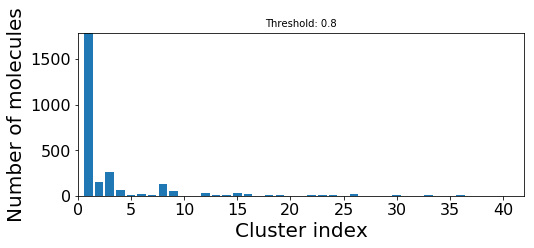

AP
Threshold:  0.9
total # clusters:  11
# clusters with only 1 compound:  2
# clusters with >5 compounds:  6
# clusters with >25 compounds:  2
# clusters with >100 compounds:  1


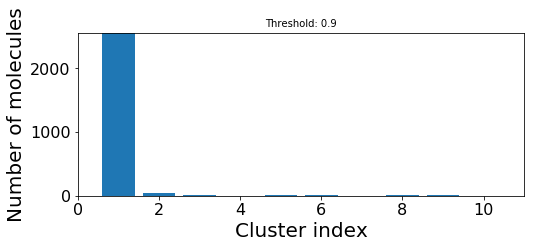

In [134]:
# cluster adenine pocket
sb = 2
fps = get_fps(data[sb])
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, sb, cutoff=i)

FP
Threshold:  0.0
total # clusters:  787
# clusters with only 1 compound:  530
# clusters with >5 compounds:  57
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


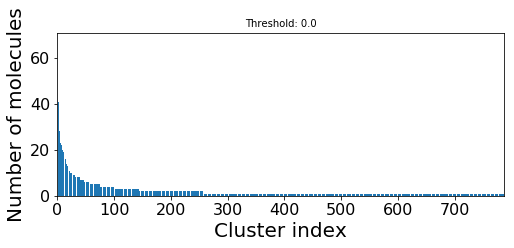

FP
Threshold:  0.1
total # clusters:  760
# clusters with only 1 compound:  498
# clusters with >5 compounds:  58
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


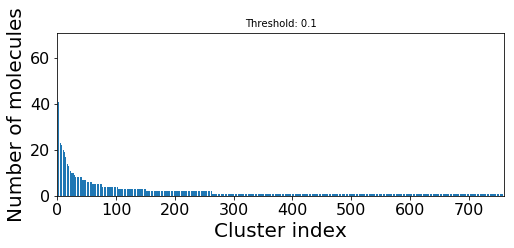

FP
Threshold:  0.2
total # clusters:  688
# clusters with only 1 compound:  422
# clusters with >5 compounds:  66
# clusters with >25 compounds:  5
# clusters with >100 compounds:  0


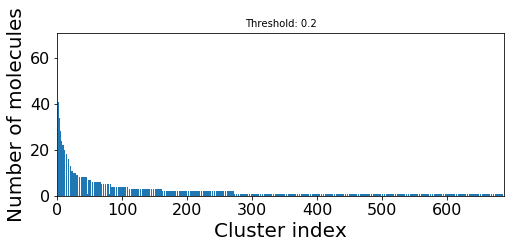

FP
Threshold:  0.30000000000000004
total # clusters:  569
# clusters with only 1 compound:  313
# clusters with >5 compounds:  62
# clusters with >25 compounds:  12
# clusters with >100 compounds:  0


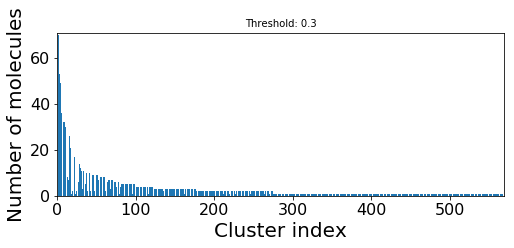

FP
Threshold:  0.4
total # clusters:  442
# clusters with only 1 compound:  218
# clusters with >5 compounds:  68
# clusters with >25 compounds:  12
# clusters with >100 compounds:  0


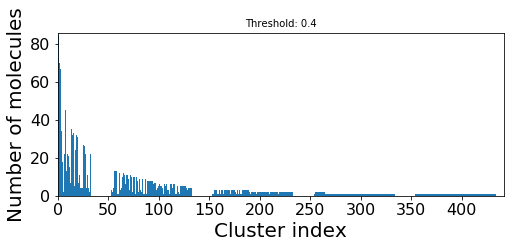

FP
Threshold:  0.5
total # clusters:  300
# clusters with only 1 compound:  129
# clusters with >5 compounds:  63
# clusters with >25 compounds:  13
# clusters with >100 compounds:  2


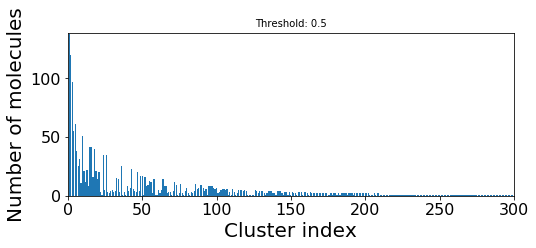

FP
Threshold:  0.6000000000000001
total # clusters:  222
# clusters with only 1 compound:  85
# clusters with >5 compounds:  59
# clusters with >25 compounds:  16
# clusters with >100 compounds:  3


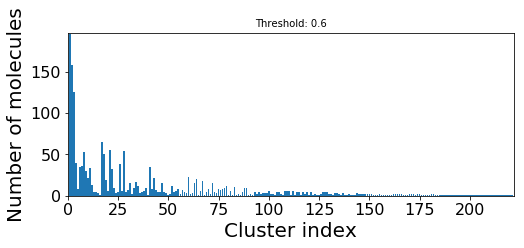

FP
Threshold:  0.7000000000000001
total # clusters:  109
# clusters with only 1 compound:  28
# clusters with >5 compounds:  47
# clusters with >25 compounds:  14
# clusters with >100 compounds:  4


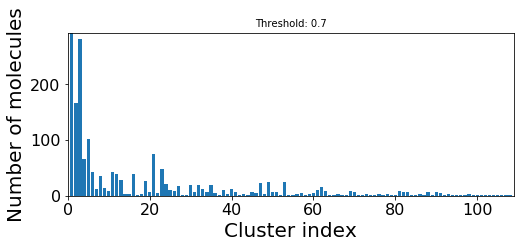

FP
Threshold:  0.8
total # clusters:  51
# clusters with only 1 compound:  10
# clusters with >5 compounds:  25
# clusters with >25 compounds:  8
# clusters with >100 compounds:  5


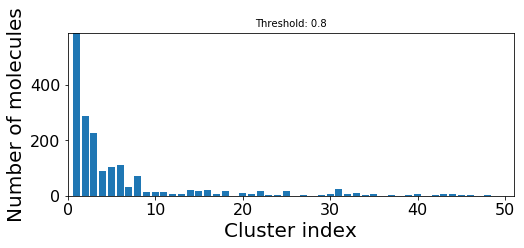

FP
Threshold:  0.9
total # clusters:  15
# clusters with only 1 compound:  3
# clusters with >5 compounds:  10
# clusters with >25 compounds:  4
# clusters with >100 compounds:  2


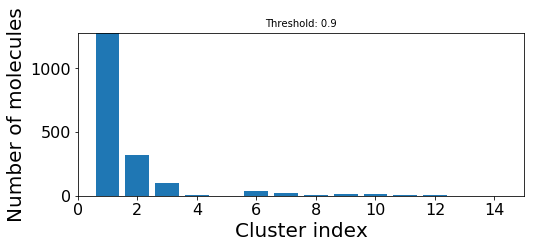

In [135]:
# cluster front pocket
sb = 0
fps = get_fps(data[sb])
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, sb, cutoff=i)

SE
Threshold:  0.0
total # clusters:  607
# clusters with only 1 compound:  405
# clusters with >5 compounds:  46
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


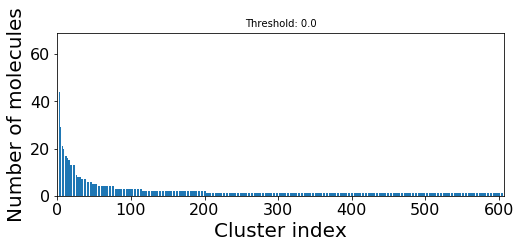

SE
Threshold:  0.1
total # clusters:  576
# clusters with only 1 compound:  377
# clusters with >5 compounds:  46
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


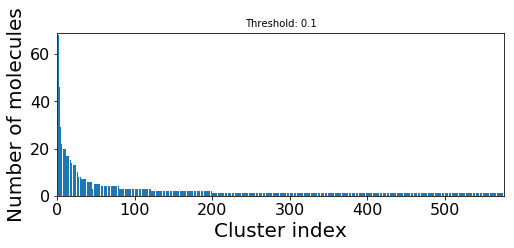

SE
Threshold:  0.2
total # clusters:  492
# clusters with only 1 compound:  302
# clusters with >5 compounds:  51
# clusters with >25 compounds:  5
# clusters with >100 compounds:  0


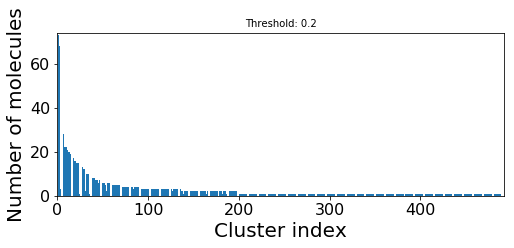

SE
Threshold:  0.30000000000000004
total # clusters:  410
# clusters with only 1 compound:  237
# clusters with >5 compounds:  49
# clusters with >25 compounds:  7
# clusters with >100 compounds:  0


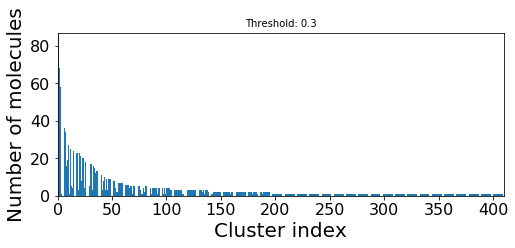

SE
Threshold:  0.4
total # clusters:  307
# clusters with only 1 compound:  157
# clusters with >5 compounds:  51
# clusters with >25 compounds:  12
# clusters with >100 compounds:  1


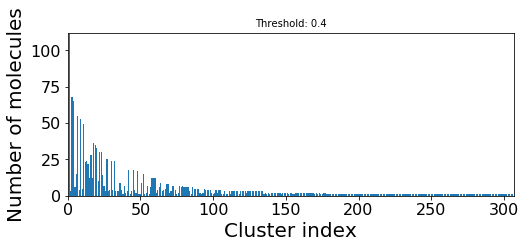

SE
Threshold:  0.5
total # clusters:  213
# clusters with only 1 compound:  89
# clusters with >5 compounds:  43
# clusters with >25 compounds:  14
# clusters with >100 compounds:  2


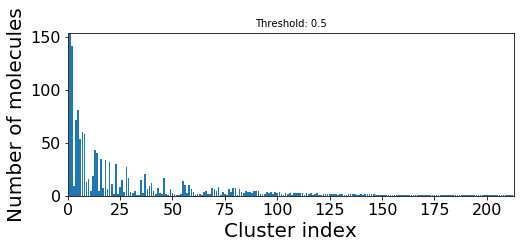

SE
Threshold:  0.6000000000000001
total # clusters:  151
# clusters with only 1 compound:  61
# clusters with >5 compounds:  39
# clusters with >25 compounds:  13
# clusters with >100 compounds:  3


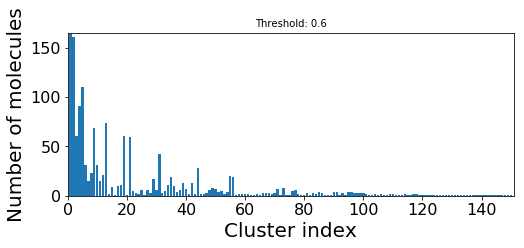

SE
Threshold:  0.7000000000000001
total # clusters:  87
# clusters with only 1 compound:  30
# clusters with >5 compounds:  27
# clusters with >25 compounds:  14
# clusters with >100 compounds:  4


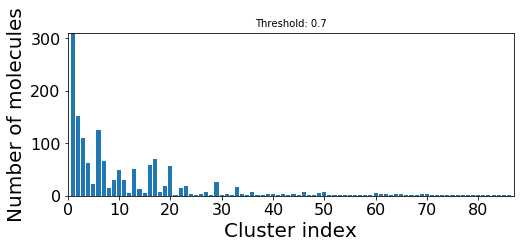

SE
Threshold:  0.8
total # clusters:  39
# clusters with only 1 compound:  8
# clusters with >5 compounds:  18
# clusters with >25 compounds:  10
# clusters with >100 compounds:  4


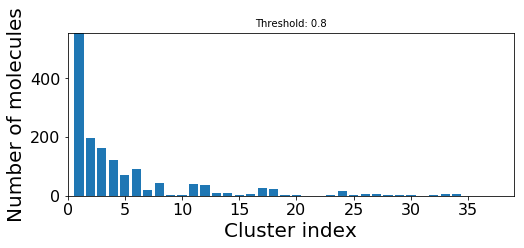

SE
Threshold:  0.9
total # clusters:  14
# clusters with only 1 compound:  3
# clusters with >5 compounds:  6
# clusters with >25 compounds:  6
# clusters with >100 compounds:  1


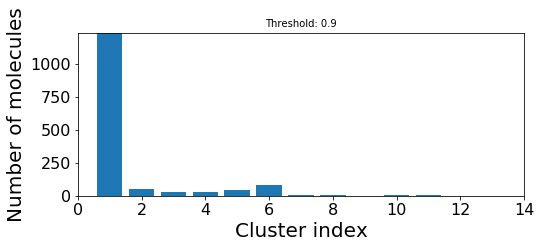

In [136]:
# cluster solvent exposed pocket
sb = 3
fps = get_fps(data[sb])
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, sb, cutoff=i)

GA
Threshold:  0.0
total # clusters:  424
# clusters with only 1 compound:  264
# clusters with >5 compounds:  43
# clusters with >25 compounds:  5
# clusters with >100 compounds:  0


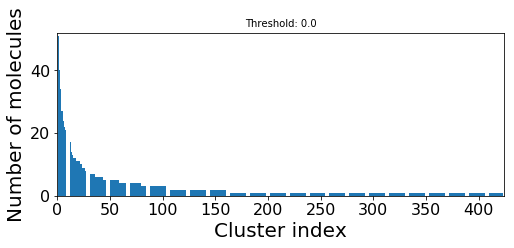

GA
Threshold:  0.1
total # clusters:  414
# clusters with only 1 compound:  250
# clusters with >5 compounds:  44
# clusters with >25 compounds:  5
# clusters with >100 compounds:  0


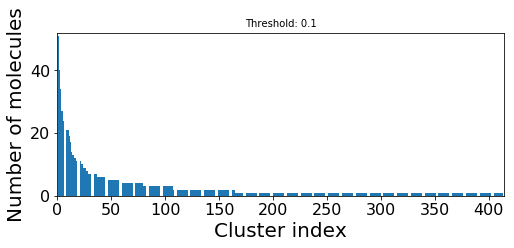

GA
Threshold:  0.2
total # clusters:  359
# clusters with only 1 compound:  205
# clusters with >5 compounds:  49
# clusters with >25 compounds:  6
# clusters with >100 compounds:  0


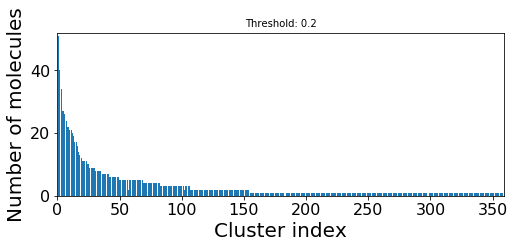

GA
Threshold:  0.30000000000000004
total # clusters:  299
# clusters with only 1 compound:  161
# clusters with >5 compounds:  48
# clusters with >25 compounds:  11
# clusters with >100 compounds:  0


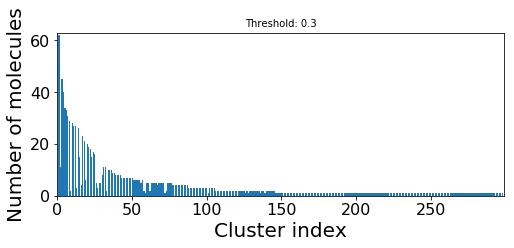

GA
Threshold:  0.4
total # clusters:  243
# clusters with only 1 compound:  120
# clusters with >5 compounds:  50
# clusters with >25 compounds:  9
# clusters with >100 compounds:  1


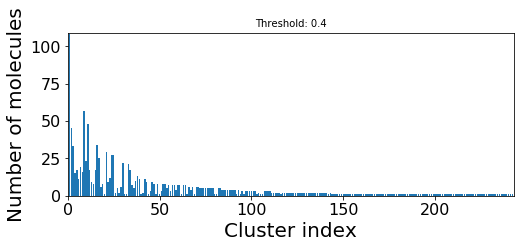

GA
Threshold:  0.5
total # clusters:  180
# clusters with only 1 compound:  85
# clusters with >5 compounds:  36
# clusters with >25 compounds:  12
# clusters with >100 compounds:  1


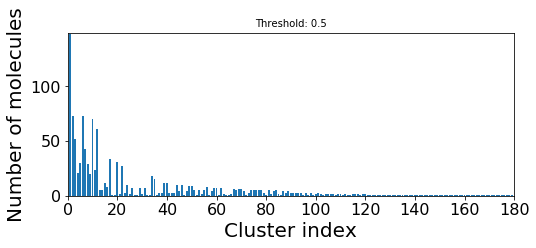

GA
Threshold:  0.6000000000000001
total # clusters:  118
# clusters with only 1 compound:  50
# clusters with >5 compounds:  36
# clusters with >25 compounds:  10
# clusters with >100 compounds:  2


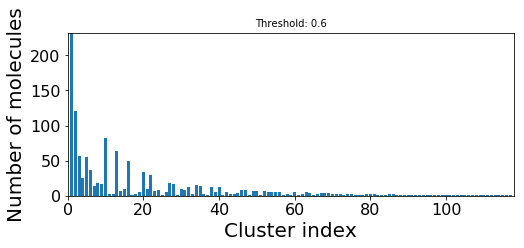

GA
Threshold:  0.7000000000000001
total # clusters:  77
# clusters with only 1 compound:  24
# clusters with >5 compounds:  28
# clusters with >25 compounds:  9
# clusters with >100 compounds:  3


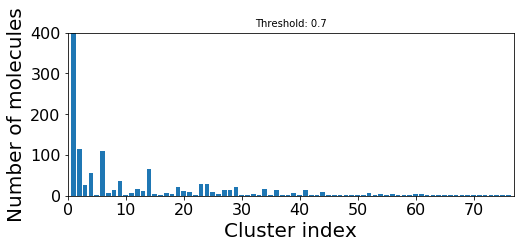

GA
Threshold:  0.8
total # clusters:  36
# clusters with only 1 compound:  6
# clusters with >5 compounds:  21
# clusters with >25 compounds:  8
# clusters with >100 compounds:  3


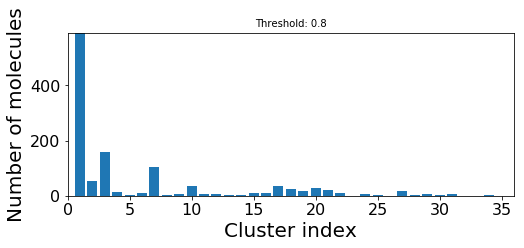

GA
Threshold:  0.9
total # clusters:  11
# clusters with only 1 compound:  1
# clusters with >5 compounds:  8
# clusters with >25 compounds:  4
# clusters with >100 compounds:  1


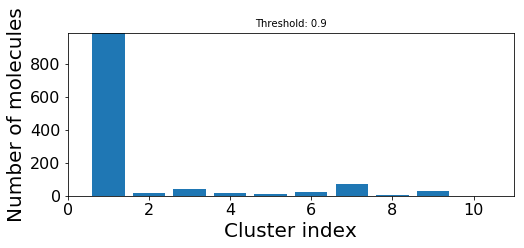

In [137]:
# cluster gate area
sb = 5
fps = get_fps(data[sb])
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, sb, cutoff=i)

B1
Threshold:  0.0
total # clusters:  52
# clusters with only 1 compound:  37
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


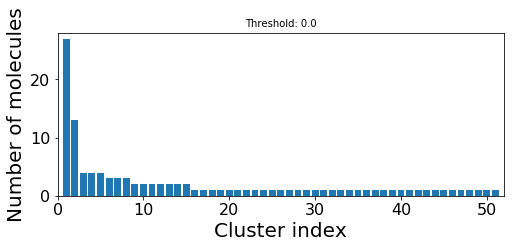

B1
Threshold:  0.1
total # clusters:  52
# clusters with only 1 compound:  37
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


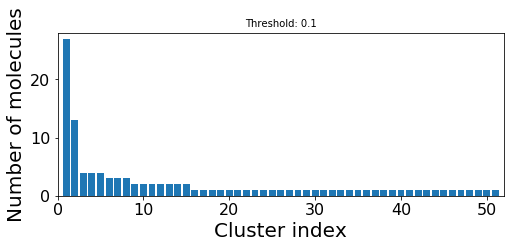

B1
Threshold:  0.2
total # clusters:  50
# clusters with only 1 compound:  34
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


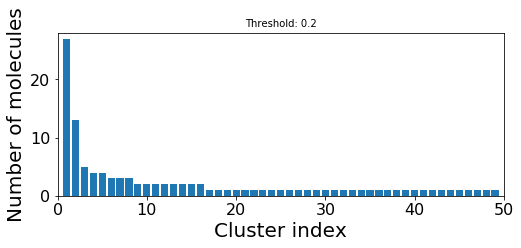

B1
Threshold:  0.30000000000000004
total # clusters:  45
# clusters with only 1 compound:  25
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


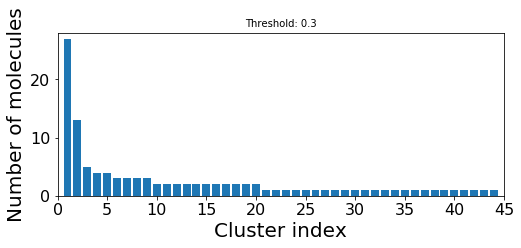

B1
Threshold:  0.4
total # clusters:  39
# clusters with only 1 compound:  23
# clusters with >5 compounds:  5
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


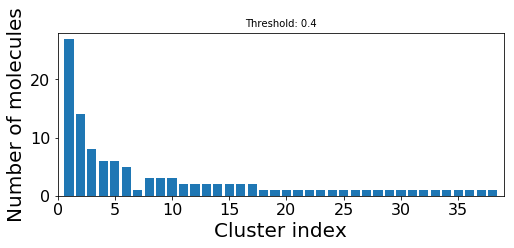

B1
Threshold:  0.5
total # clusters:  33
# clusters with only 1 compound:  19
# clusters with >5 compounds:  5
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


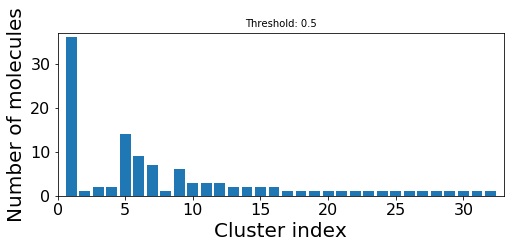

B1
Threshold:  0.6000000000000001
total # clusters:  31
# clusters with only 1 compound:  16
# clusters with >5 compounds:  4
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


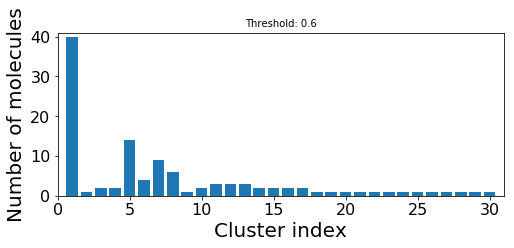

B1
Threshold:  0.7000000000000001
total # clusters:  21
# clusters with only 1 compound:  11
# clusters with >5 compounds:  4
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


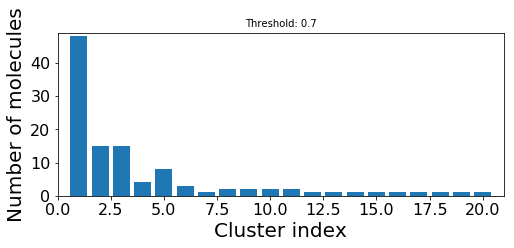

B1
Threshold:  0.8
total # clusters:  18
# clusters with only 1 compound:  6
# clusters with >5 compounds:  4
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


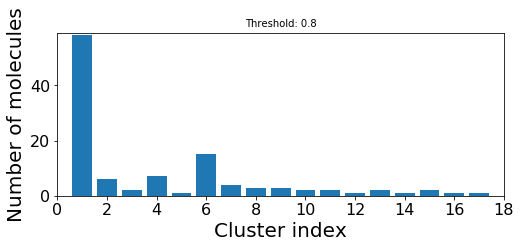

B1
Threshold:  0.9
total # clusters:  7
# clusters with only 1 compound:  1
# clusters with >5 compounds:  3
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


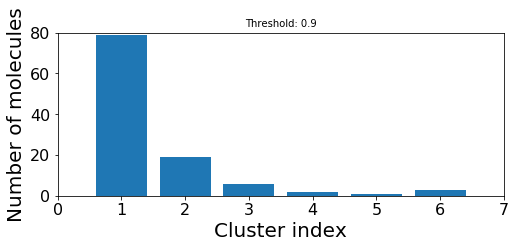

In [138]:
# cluster back pocket I
sb = 4
fps = get_fps(data[sb])
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, sb, cutoff=i)

B2
Threshold:  0.0
total # clusters:  122
# clusters with only 1 compound:  82
# clusters with >5 compounds:  7
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


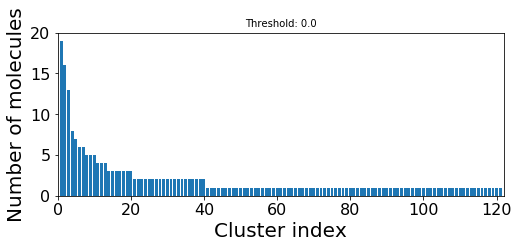

B2
Threshold:  0.1
total # clusters:  119
# clusters with only 1 compound:  78
# clusters with >5 compounds:  7
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


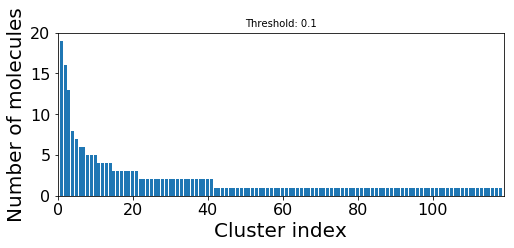

B2
Threshold:  0.2
total # clusters:  112
# clusters with only 1 compound:  69
# clusters with >5 compounds:  8
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


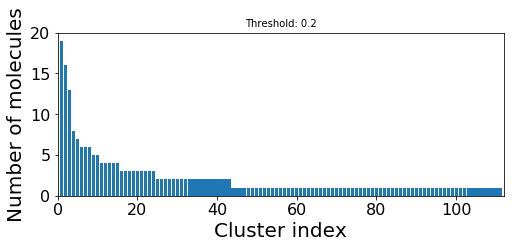

B2
Threshold:  0.30000000000000004
total # clusters:  101
# clusters with only 1 compound:  58
# clusters with >5 compounds:  10
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


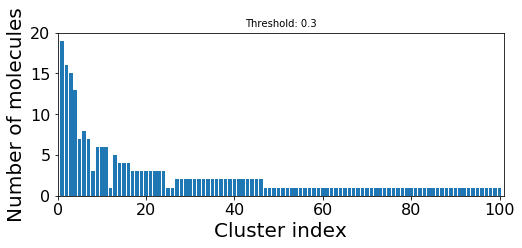

B2
Threshold:  0.4
total # clusters:  86
# clusters with only 1 compound:  41
# clusters with >5 compounds:  10
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


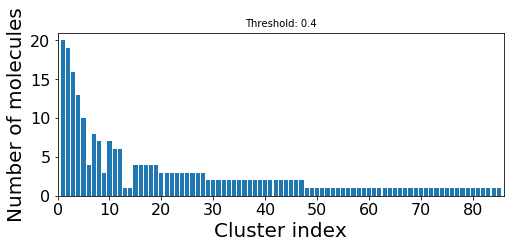

B2
Threshold:  0.5
total # clusters:  72
# clusters with only 1 compound:  31
# clusters with >5 compounds:  10
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


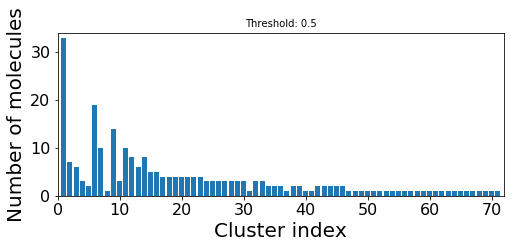

B2
Threshold:  0.6000000000000001
total # clusters:  60
# clusters with only 1 compound:  22
# clusters with >5 compounds:  11
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


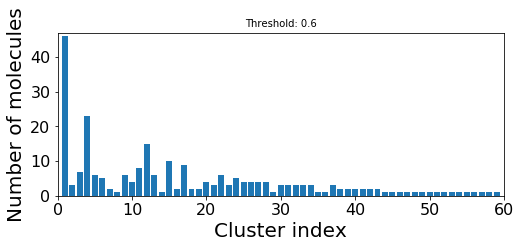

B2
Threshold:  0.7000000000000001
total # clusters:  35
# clusters with only 1 compound:  7
# clusters with >5 compounds:  10
# clusters with >25 compounds:  2
# clusters with >100 compounds:  0


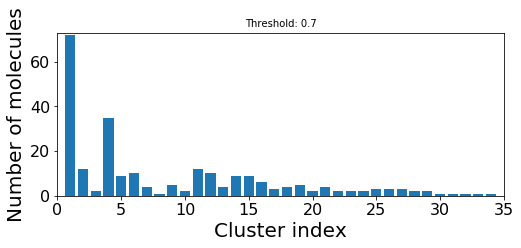

B2
Threshold:  0.8
total # clusters:  24
# clusters with only 1 compound:  7
# clusters with >5 compounds:  8
# clusters with >25 compounds:  2
# clusters with >100 compounds:  1


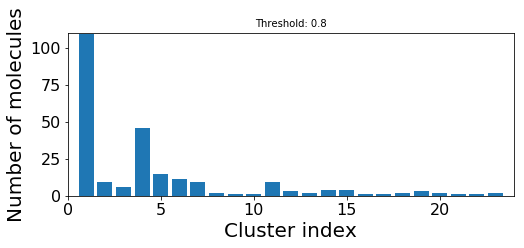

B2
Threshold:  0.9
total # clusters:  10
# clusters with only 1 compound:  2
# clusters with >5 compounds:  6
# clusters with >25 compounds:  1
# clusters with >100 compounds:  1


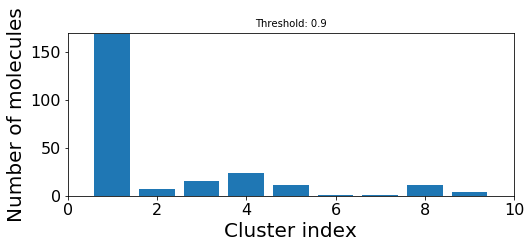

In [139]:
# cluster back pocket II
sb = 1
fps = get_fps(data[sb])
for i in np.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fps, cutoff=i)
    analyze_clusters(clusters, sb, cutoff=i)

## Investigate clusters:

In [101]:
def principal_components(X):
    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    X = pca.transform(X)
    return [p[0] for p in X], [p[1] for p in X]

In [125]:
def find_cluster_mcs(cluster, frags):
    mols = [frags[i] for i in cluster]
    mcs = rdFMCS.FindMCS(mols, threshold=0.8)
    substructure = Chem.MolFromSmarts(mcs.smartsString)
    return substructure

In [307]:
def cluster_scatter_plots(x, y, clusters, n_clusters, sb):
    
    X, Y = [], []
    kinases = get_kinases(data[sb])
    kinasesXY = []
    cluster_colors = []#np.empty(len(points), dtype=object)
    for p, point in enumerate(x):
        for c, cluster in enumerate(clusters[:n_clusters]):
            if p in cluster:
                cluster_colors.append(c)
                X.append(point)
                Y.append(y[p])
                kinasesXY.append(kinases[p])

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.scatter(X, Y, c=cluster_colors, s=20, cmap='brg')
    plt.title(str(n_clusters)+' largest clusters in '+str(subpockets[sb])+' colored by cluster')

    # find kinase colors
    kinase_set = list(set(kinasesXY))
    kinase_colors = []
    for k, kinase in enumerate(kinasesXY):
        kinase_colors.append(kinase_set.index(kinase))

    plt.subplot(1,2,2)
    plt.scatter(X, Y, c=kinase_colors, s=20, cmap='brg')
    plt.title(str(n_clusters)+' largest clusters in '+str(subpockets[sb])+' colored by kinase')
    plt.show()
    
    return None

## ADENINE POCKET:

AP
Threshold:  0.4
total # clusters:  560
# clusters with only 1 compound:  294
# clusters with >5 compounds:  96
# clusters with >25 compounds:  18
# clusters with >100 compounds:  2


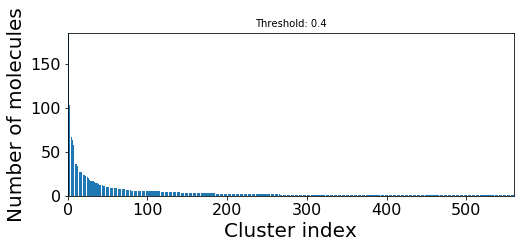

Total number of fragments:  2670


In [308]:
# investigate adenine pocket clusters
sb = 2
cutoff = 0.4
fps = get_fps(data[sb])
frags = get_mols(data[sb])

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
analyze_clusters(clusters, sb, cutoff)

print('Total number of fragments: ', len(frags))

In [309]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

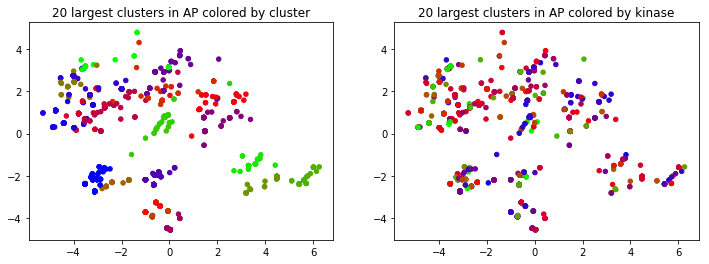

In [310]:
# plot clusters
n_clusters = 20
cluster_scatter_plots(x, y, clusters, n_clusters, sb)

Maximum common substructure per cluster: 


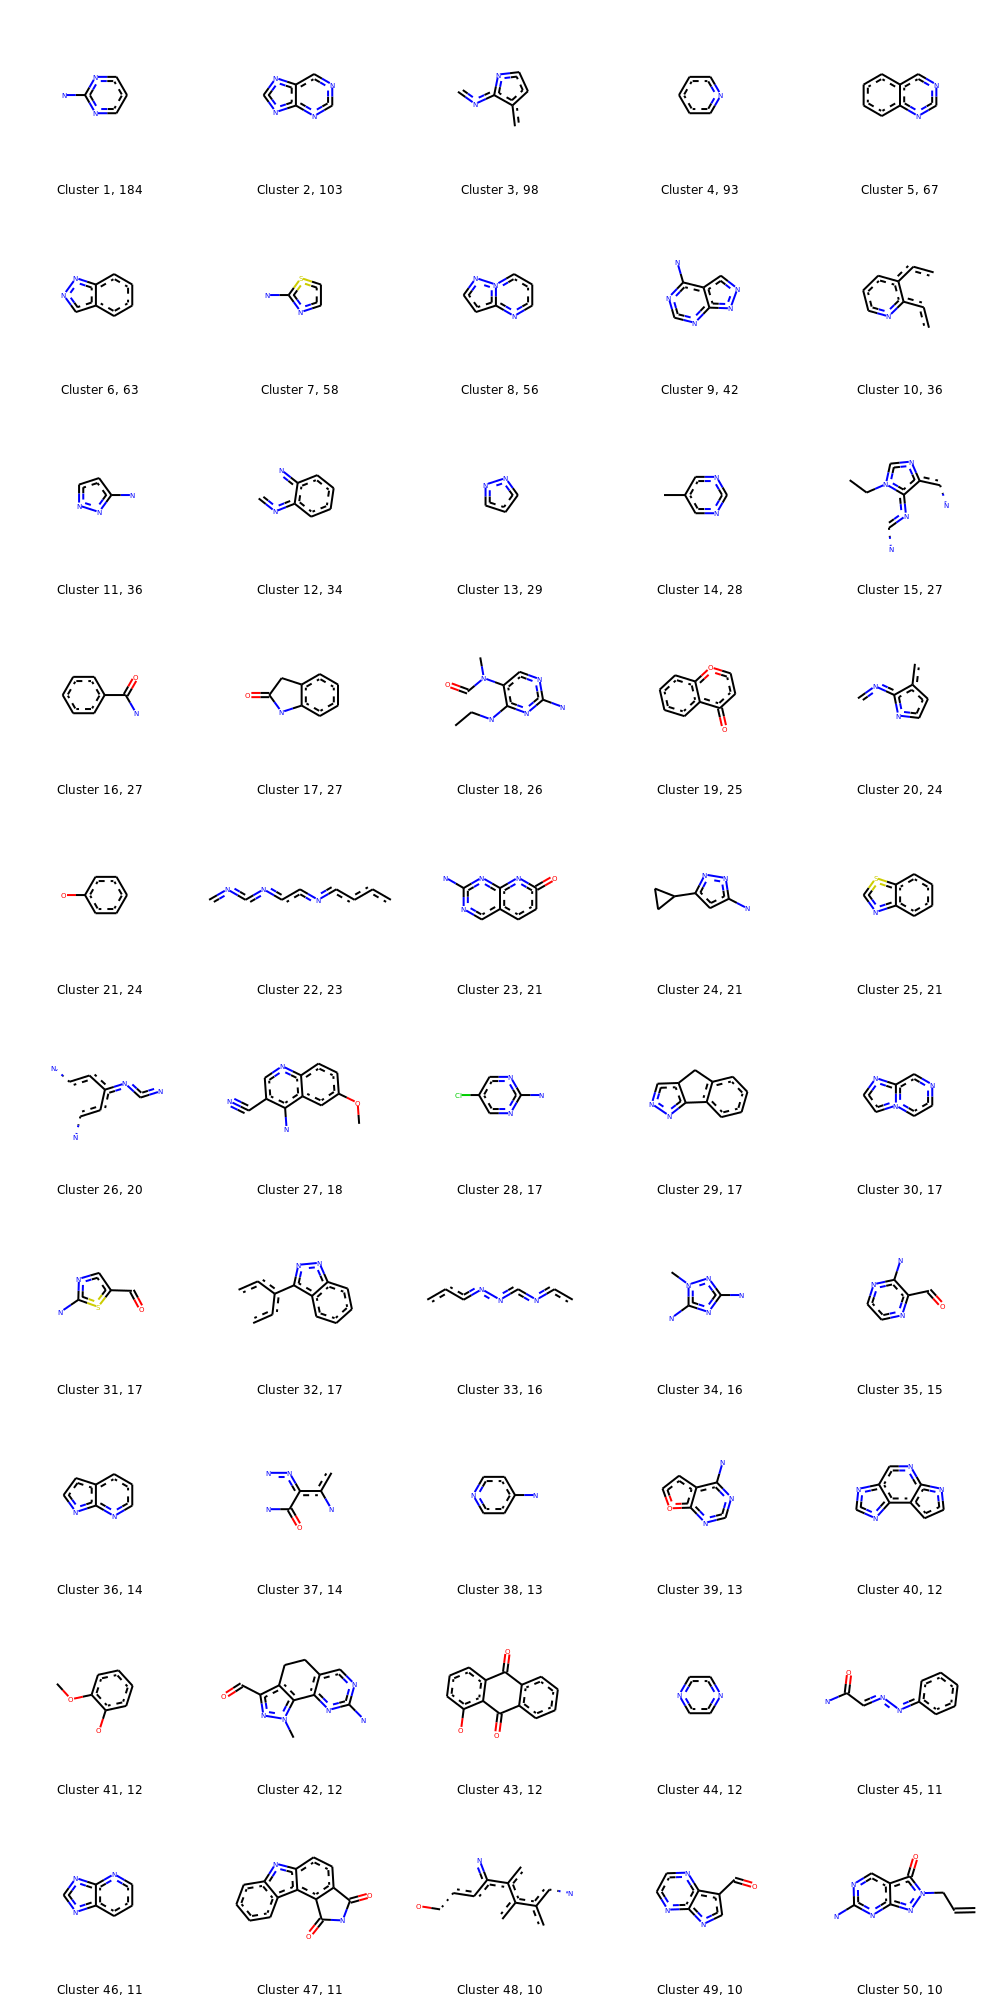

In [311]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:50]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
               
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## FRONT POCKET:

FP
Threshold:  0.5
total # clusters:  300
# clusters with only 1 compound:  129
# clusters with >5 compounds:  63
# clusters with >25 compounds:  13
# clusters with >100 compounds:  2


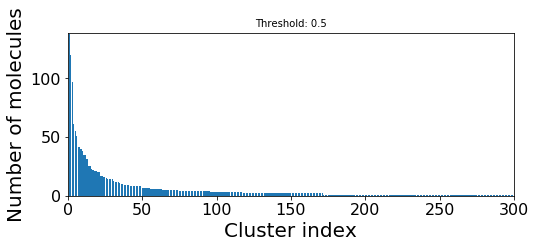

Total number of fragments:  1811


In [312]:
# investigate front pocket
sb = 0
cutoff = 0.5
fps = get_fps(data[sb])
frags = get_mols(data[sb])

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, sb, cutoff)

print('Total number of fragments: ', len(frags))

In [313]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

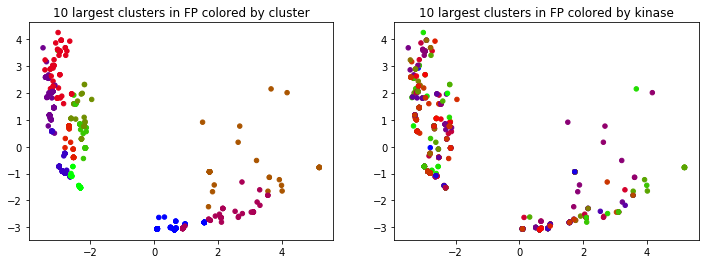

In [314]:
# plot clusters
n_clusters = 10
cluster_scatter_plots(x, y, clusters, n_clusters, sb)

Maximum common substructure per cluster: 


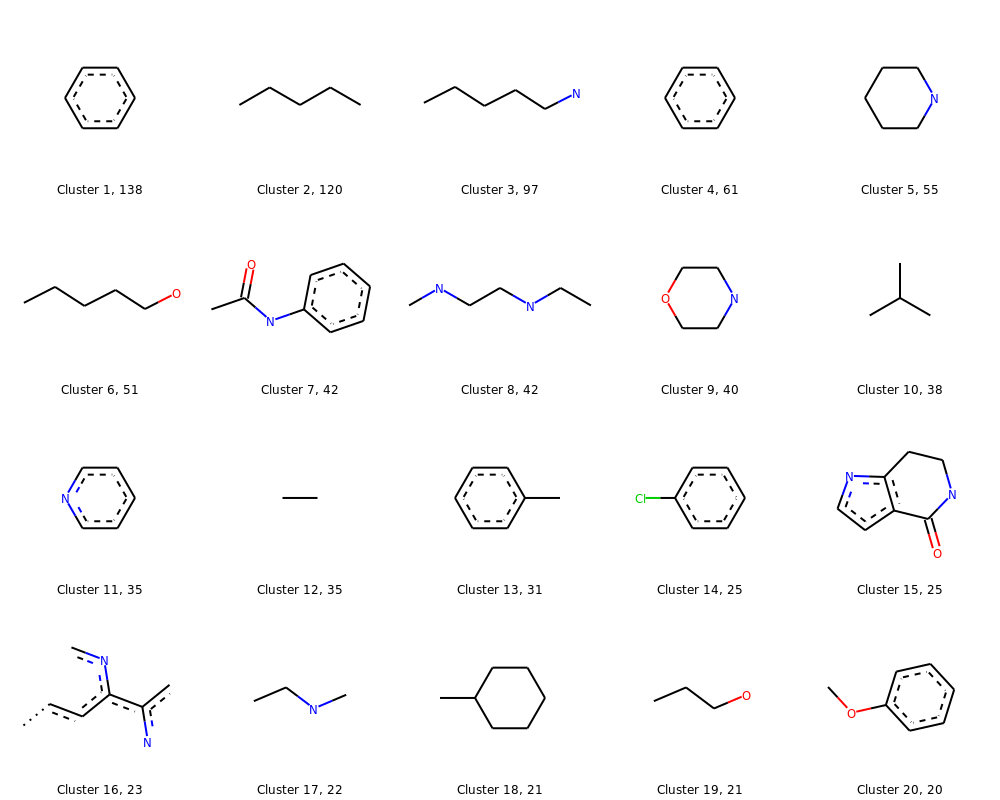

In [315]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:20]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## SE POCKET:

SE
Threshold:  0.5
total # clusters:  213
# clusters with only 1 compound:  89
# clusters with >5 compounds:  43
# clusters with >25 compounds:  14
# clusters with >100 compounds:  2


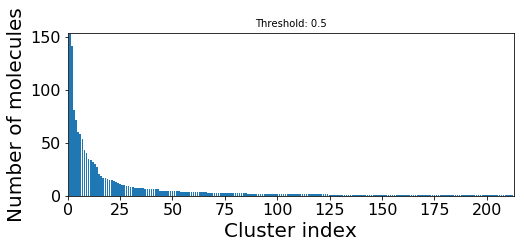

Total number of fragments:  1487


In [316]:
# investigate solvent exposed pocket
sb = 3
cutoff = 0.5
fps = get_fps(data[sb])
frags = get_mols(data[sb])

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, sb, cutoff)

print('Total number of fragments: ', len(frags))

In [317]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

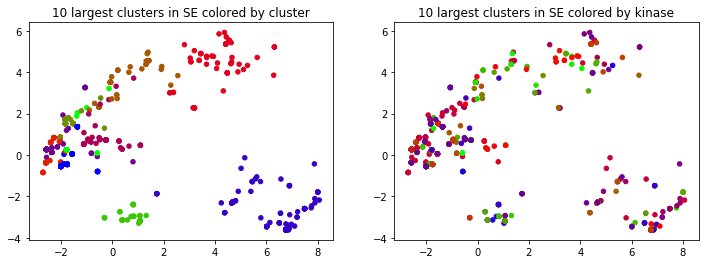

In [318]:
# plot clusters
n_clusters = 10
cluster_scatter_plots(x, y, clusters, n_clusters, sb)

Maximum common substructure per cluster: 


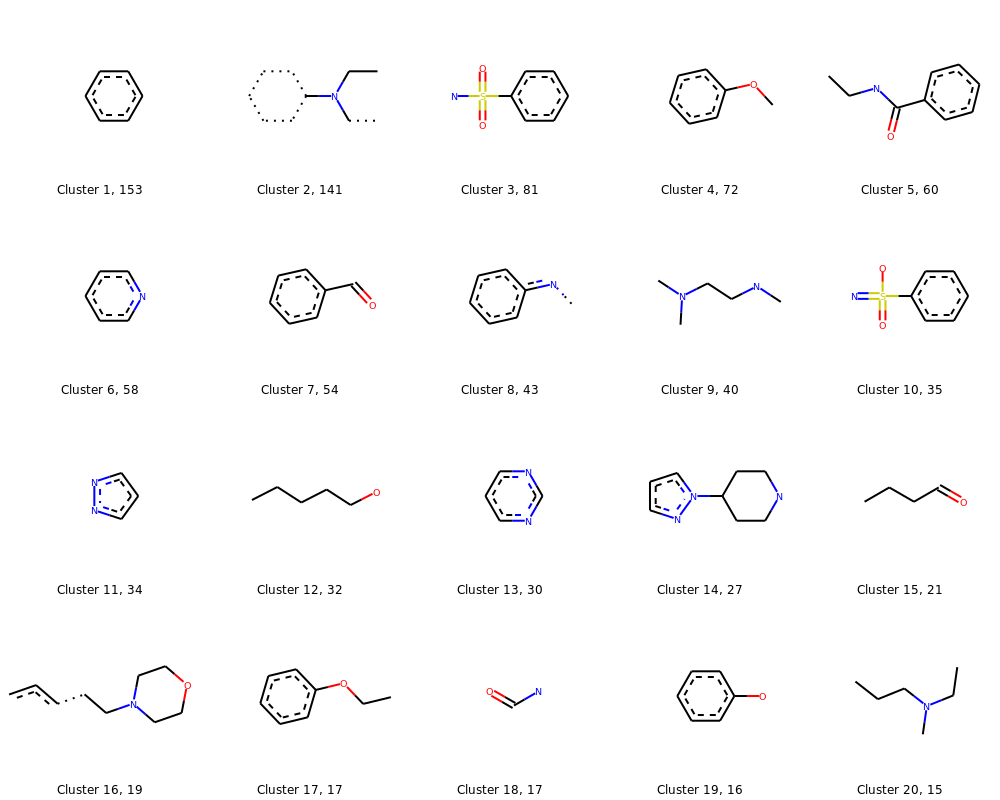

In [319]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:20]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## GATE AREA:

GA
Threshold:  0.5
total # clusters:  180
# clusters with only 1 compound:  85
# clusters with >5 compounds:  36
# clusters with >25 compounds:  12
# clusters with >100 compounds:  1


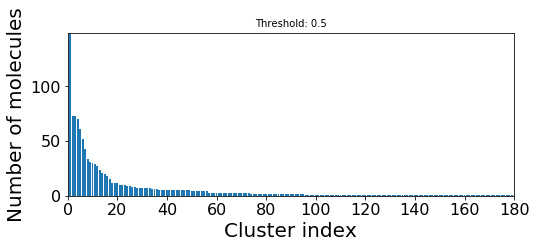

Total number of fragments:  1202


In [320]:
# investigate gate area
sb = 5
cutoff = 0.5
fps = get_fps(data[sb])
frags = get_mols(data[sb])

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, sb, cutoff)
print('Total number of fragments: ', len(frags))

In [321]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

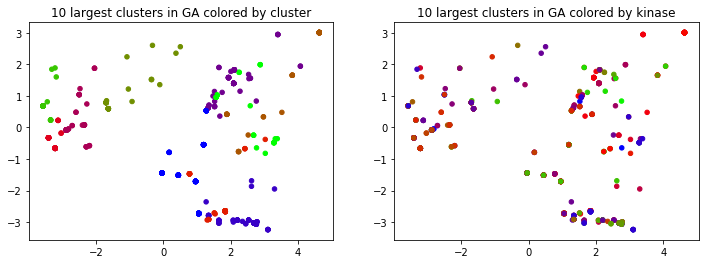

In [325]:
# plot clusters
n_clusters = 10
cluster_scatter_plots(x, y, clusters, n_clusters, sb)

Maximum common substructure per cluster: 


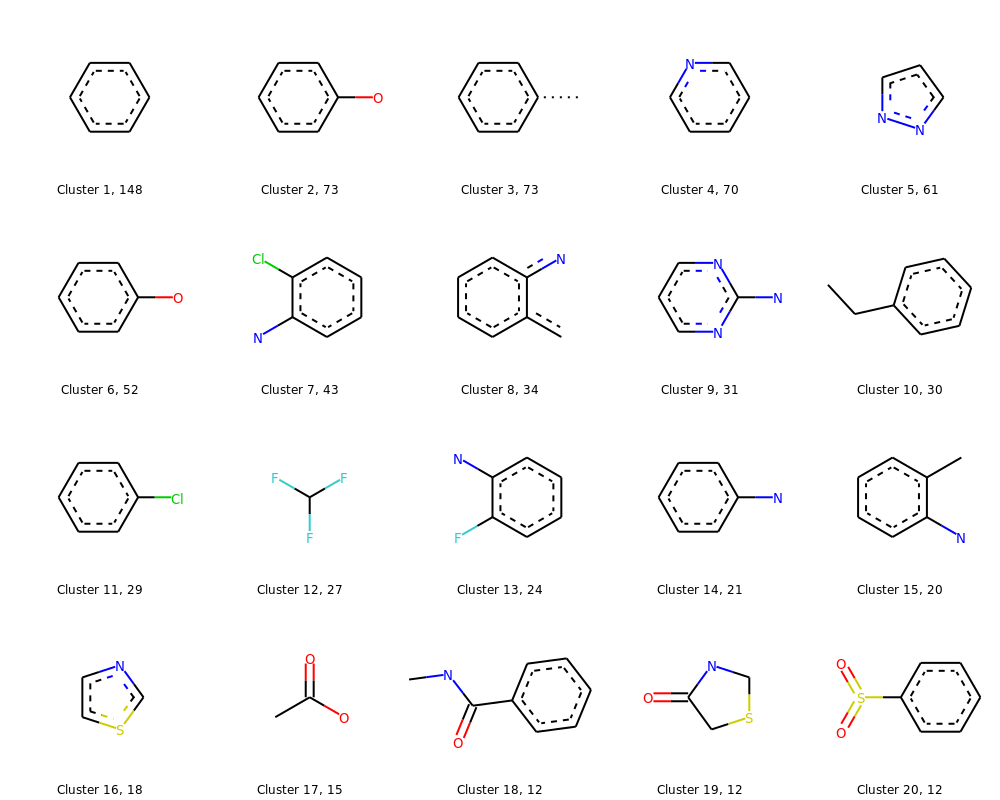

In [326]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:20]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## BACK POCKET I

B1
Threshold:  0.2
total # clusters:  50
# clusters with only 1 compound:  34
# clusters with >5 compounds:  2
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


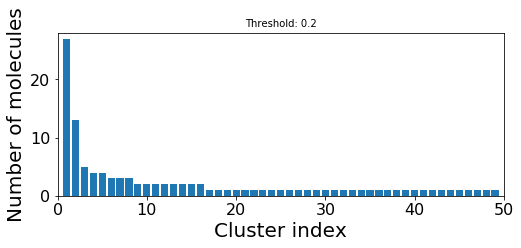

Total number of fragments:  112


In [327]:
# investigate back pocket I
sb = 4
cutoff = 0.2
fps = get_fps(data[sb])
frags = get_mols(data[sb])

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, sb, cutoff)
print('Total number of fragments: ', len(frags))

In [328]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

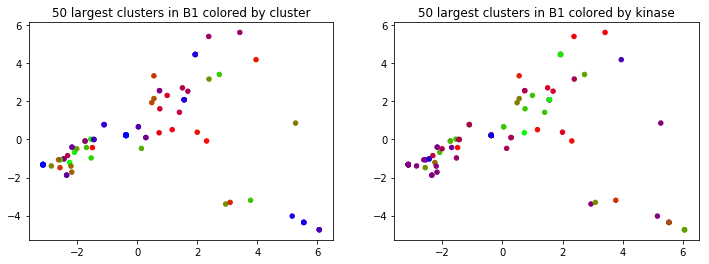

In [331]:
# plot clusters
n_clusters = 50
cluster_scatter_plots(x, y, clusters, n_clusters, sb)

Maximum common substructure per cluster: 


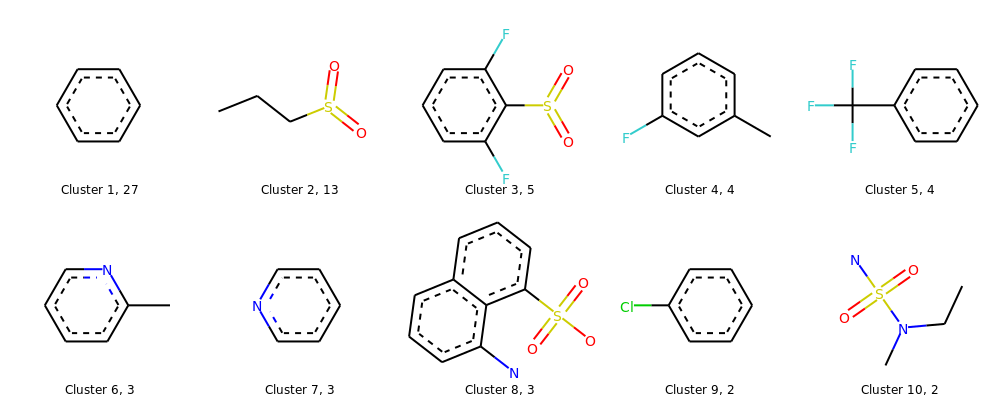

In [332]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:10]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)

## BACK POCKET II

B2
Threshold:  0.5
total # clusters:  72
# clusters with only 1 compound:  31
# clusters with >5 compounds:  10
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


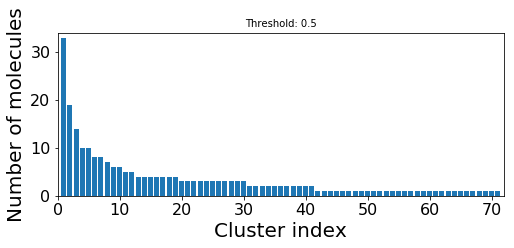

Total number of fragments:  245


In [333]:
# investigate back pocket II
sb = 1
cutoff = 0.5
fps = get_fps(data[sb])
frags = get_mols(data[sb])

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)

analyze_clusters(clusters, sb, cutoff)
print('Total number of fragments: ', len(frags))

In [334]:
# convert the RDKit explicit vectors into numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# PCA
x, y = principal_components(np_fps)

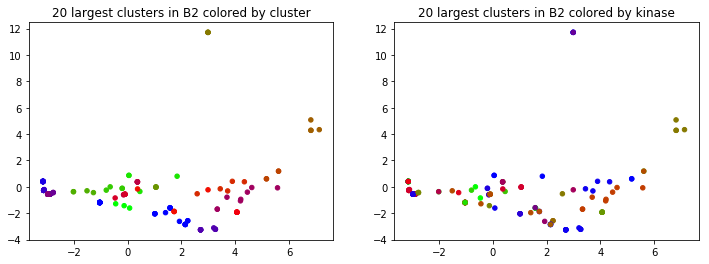

In [336]:
# plot clusters
n_clusters = 20
cluster_scatter_plots(x, y, clusters, n_clusters, sb)

Maximum common substructure per cluster: 


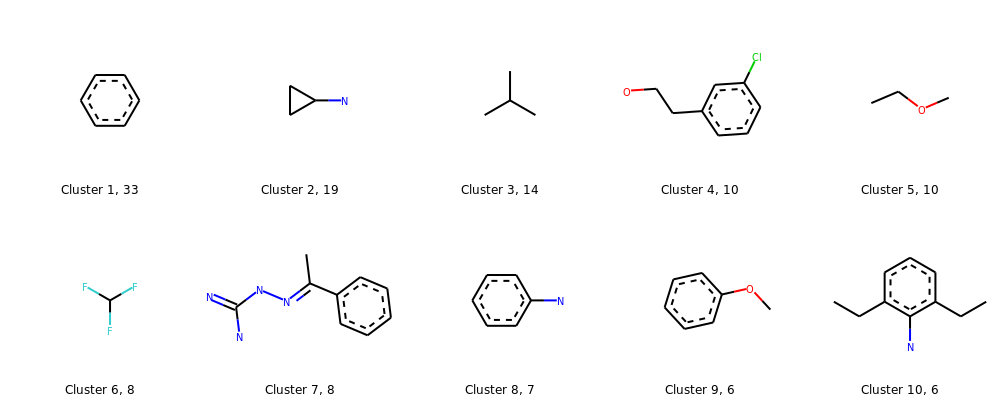

In [337]:
substructures = []
legends = []
# plot MCS for largest clusters
for i, cluster in enumerate(clusters[:10]):
    mcs = find_cluster_mcs(cluster, frags)
    substructures.append(mcs)
    legend = 'Cluster '+str(i+1)+', '+str(len(cluster))
    legends.append(legend)
        
print('Maximum common substructure per cluster: ') 
Draw.MolsToGridImage(substructures, legends=legends, molsPerRow=5)